# 0.0 BIBLIOTECAS

In [56]:
# manipulaçao de dados
import numpy  as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
from matplotlib import pyplot as plt
import pickle

# machinelearning
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# avaliações
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import GridSearchCV

##  0.1. FUNÇÕES

In [57]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.2 DATASET

In [58]:
df_raw = pd.read_csv('C:/Users/luizv/repositorio/propensao_venda/seguro/train.csv')


# 1.0 DESCRIÇÃO DOS DADOS

In [59]:
df1 = df_raw.copy()

## 1.1. Renomear Colunas

In [60]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

## 1.2 Dimensão do dataset

In [61]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3 Tipo dos dados

In [62]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Dados nulos

In [63]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Atributos numéricos e categóricos

In [64]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1 Atributos numéricos

In [65]:
 # Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


#  2.0. Feature Engineering

id: ID único do cliente

Gender: Gênero do cliente

Age: Idade do cliente

Driving_License: 1: Cliente já possui CNH,  0: Cliente não possui CNH

Region_Code: Código único da região do cliente

Previously_Insured: 1: Cliente já possui seguro de veículo, 0: Cliente não possui seguro de veículo

Vehicle_Age: Idade do veículo

Vehicle_Damage: 1: Cliente teve seu veículo danificado no passado, 0: Cliente não teve seu veículo danificado no passado

Annual_Premium: O valor que o cliente precisa pagar como prêmio no ano

Policy_Sales_Channel: Código anonimizado para o canal de abordagem ao cliente

Vintage: Número de dias em que o cliente está associado à empresa

Response: 1: Cliente está interessado, 0: Cliente não está interessado

In [66]:
df2 = df1.copy()

# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0 Filtro dos dados

In [67]:
 df3 = df2.copy()

# 4.0 EDA

In [68]:
df4= df3.copy()

## 4.1 Gender 

## 4.1.1 Relação entre gênero e adesão 

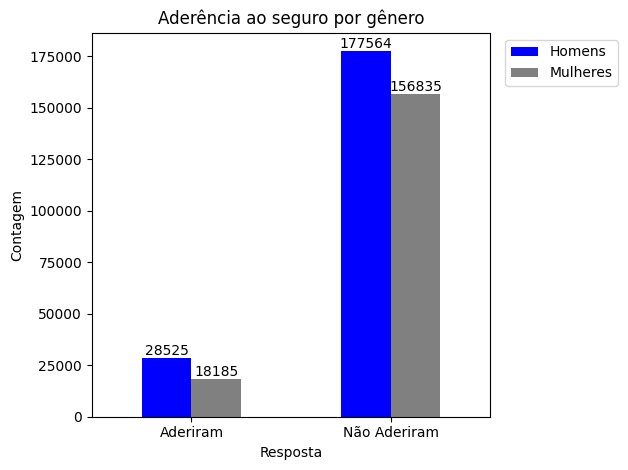

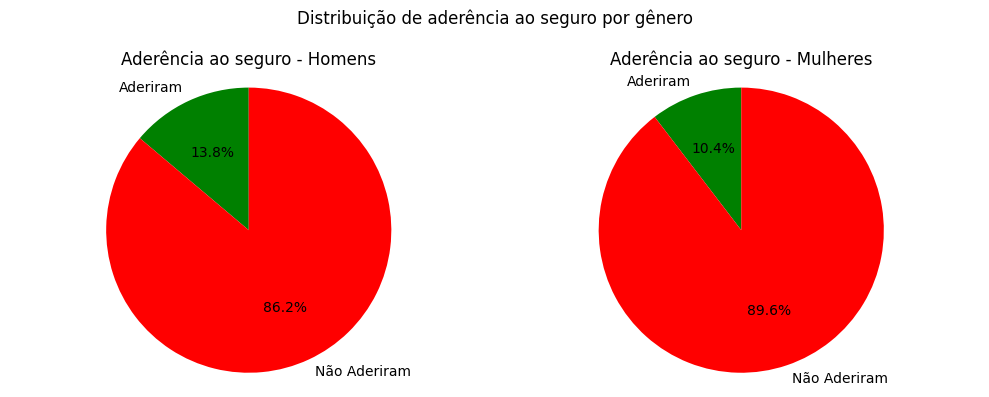

In [69]:
import matplotlib.pyplot as plt

# Filtro
homens_aderiram = df4[(df4['gender'] == 'Male') & (df4['response'] == 1)]
homens_nao_aderiram = df4[(df4['gender'] == 'Male') & (df4['response'] == 0)]

mulheres_aderiram = df4[(df4['gender'] == 'Female') & (df4['response'] == 1)]
mulheres_nao_aderiram = df4[(df4['gender'] == 'Female') & (df4['response'] == 0)]

# Dataframe para o gráfico de barras
data = {
    'Homens': [len(homens_aderiram), len(homens_nao_aderiram)],
    'Mulheres': [len(mulheres_aderiram), len(mulheres_nao_aderiram)]
}
df_contagem = pd.DataFrame(data, index=['Aderiram', 'Não Aderiram'])

# Cores para o gráfico de barras
cores = {'Homens': 'blue', 'Mulheres': 'gray'}

# Plot do gráfico de barras com cores personalizadas
ax = df_contagem.plot(kind='bar', rot=0, color=[cores[coluna] for coluna in df_contagem.columns])

# Adicionar contagem em cima das barras
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, y + height), ha='center', va='bottom')

plt.xlabel('Resposta')
plt.ylabel('Contagem')
plt.title('Aderência ao seguro por gênero')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  # Reposicionar a legenda
plt.tight_layout()  # Ajustar layout para evitar sobreposição

# Gráficos de pizza
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de pizza para os homens
homens = [len(homens_aderiram), len(homens_nao_aderiram)]
labels_homens = ['Aderiram', 'Não Aderiram']
colors_homens = ['green', 'red']
axes[0].pie(homens, labels=labels_homens, colors=colors_homens, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Aderência ao seguro - Homens')
axes[0].axis('equal')  # Torna o gráfico de pizza circular

# Gráfico de pizza para as mulheres
mulheres = [len(mulheres_aderiram), len(mulheres_nao_aderiram)]
labels_mulheres = ['Aderiram', 'Não Aderiram']
colors_mulheres = ['green', 'red']
axes[1].pie(mulheres, labels=labels_mulheres, colors=colors_mulheres, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Aderência ao seguro - Mulheres')
axes[1].axis('equal')  # Torna o gráfico de pizza circular

plt.suptitle('Distribuição de aderência ao seguro por gênero')
plt.tight_layout()
plt.show()


## 4.2 Age

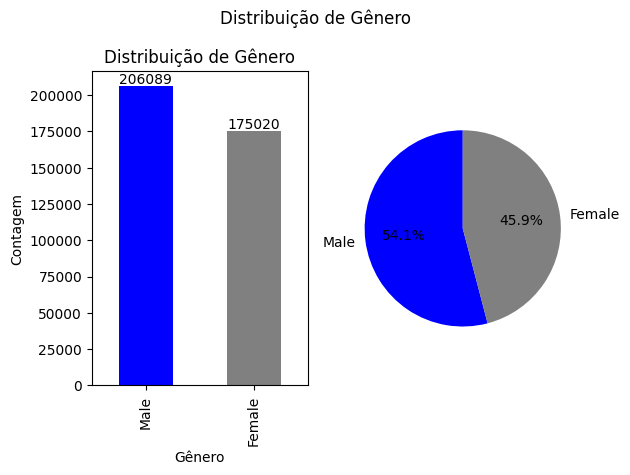

In [70]:
# Filtro
gender = df4['gender'].value_counts()

# Coloração
colors = ['blue', 'gray']

# Plot de barras
plt.subplot(1, 2, 1)
ax = gender.plot(kind='bar', color=colors)
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.title('Distribuição de Gênero')

# Adicionar quantidade em cima de cada barra
for i, v in enumerate(gender):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Plot de pizza
plt.subplot(1, 2, 2)  
plt.pie(gender, labels=gender.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  

plt.suptitle('Distribuição de Gênero')
plt.tight_layout()
plt.show()


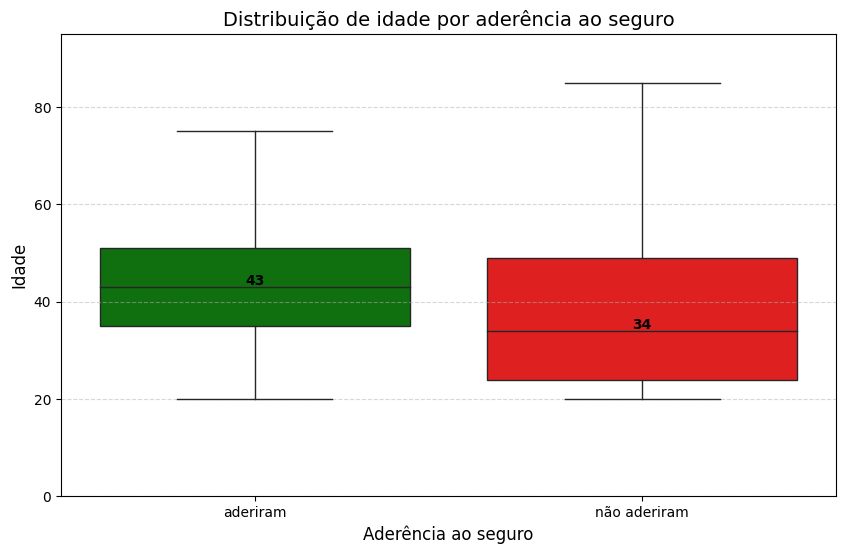

In [71]:
# Filtro
df4['response_label'] = df4['response'].replace({1: 'aderiram', 0: 'não aderiram'})

# Plot
plt.figure(figsize=(10, 6))

# Definir as cores dos boxplots
colors = {'aderiram': 'green', 'não aderiram': 'red'}

# Plotar o boxplot
ax = sns.boxplot(x='response_label', y='age', data=df4, showfliers=False, palette=colors, linewidth=1)

# Configurar o título e os rótulos dos eixos
plt.xlabel('Aderência ao seguro', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.title('Distribuição de idade por aderência ao seguro', fontsize=14)

# Ajustar a escala do eixo y
plt.ylim(0, df4['age'].max() + 10)

# Adicionar grade no gráfico
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adicionar principais valores do boxplot
medians = df4.groupby('response_label')['age'].median()
medians_labels = [str(int(x)) for x in medians.values]
pos = range(len(medians))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.5, medians_labels[tick],
            horizontalalignment='center', color='black', weight='bold')

plt.show()

## 4.2.1  Distribuição da idade e aderência

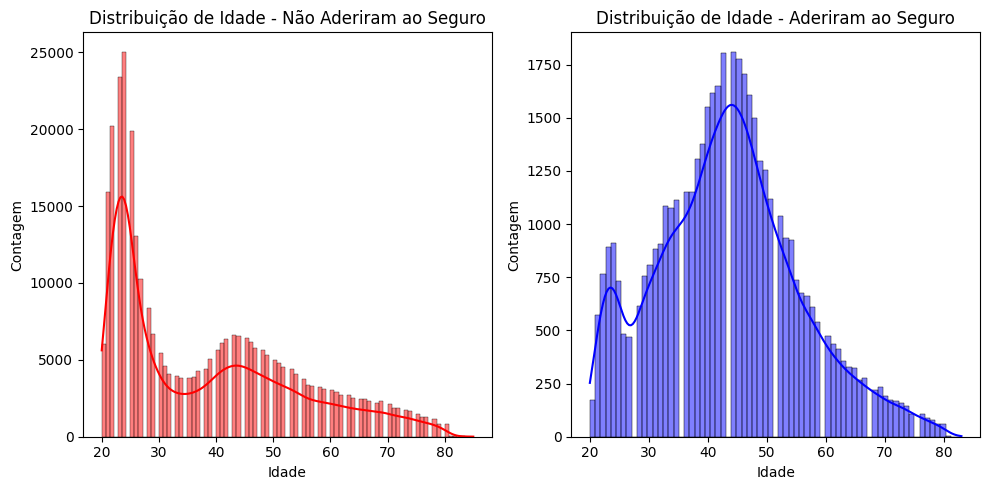

In [72]:
# filtro
nao_aderiram=df4.loc[df4['response'] == 0, 'age']
aderiram=df4.loc[df4['response'] == 1, 'age']

# subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# gráfico não aderiram ao seguro
sns.histplot(nao_aderiram, kde=True, ax=axs[0], color='red', edgecolor='black')
axs[0].set_xlabel('Idade')
axs[0].set_ylabel('Contagem')
axs[0].set_title('Distribuição de Idade - Não Aderiram ao Seguro')

# gráfico aderiram ao seguro
sns.histplot(aderiram, kde=True, ax=axs[1], color='blue', edgecolor='black')
axs[1].set_xlabel('Idade')
axs[1].set_ylabel('Contagem')
axs[1].set_title('Distribuição de Idade - Aderiram ao Seguro')

# Ajustar o espaçamento entre os subplots
plt.tight_layout()
plt.show()

## 4.3 Driving license e adesão ao seguro

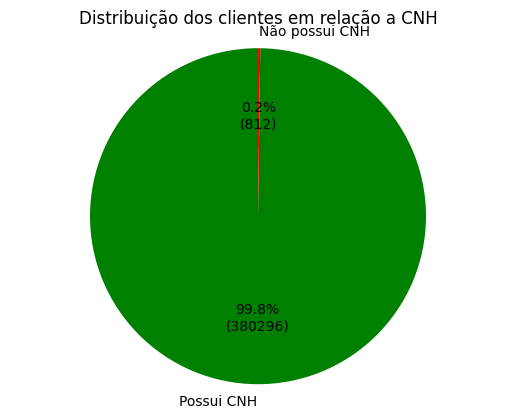

In [73]:
# filtro
count_cnh = df4['driving_license'].value_counts()

# Configurar os rótulos e as cores
labels = ['Possui CNH', 'Não possui CNH']
colors = ['green', 'red']

# Plota
plt.pie(count_cnh, labels=labels, colors=colors, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(count_cnh))})",
        startangle=90)
plt.axis('equal')
plt.title('Distribuição dos clientes em relação a CNH')

# Exibir o gráfico
plt.show()

## 4.3.1 Relação entre as pessoas que possuem CNH por sexo

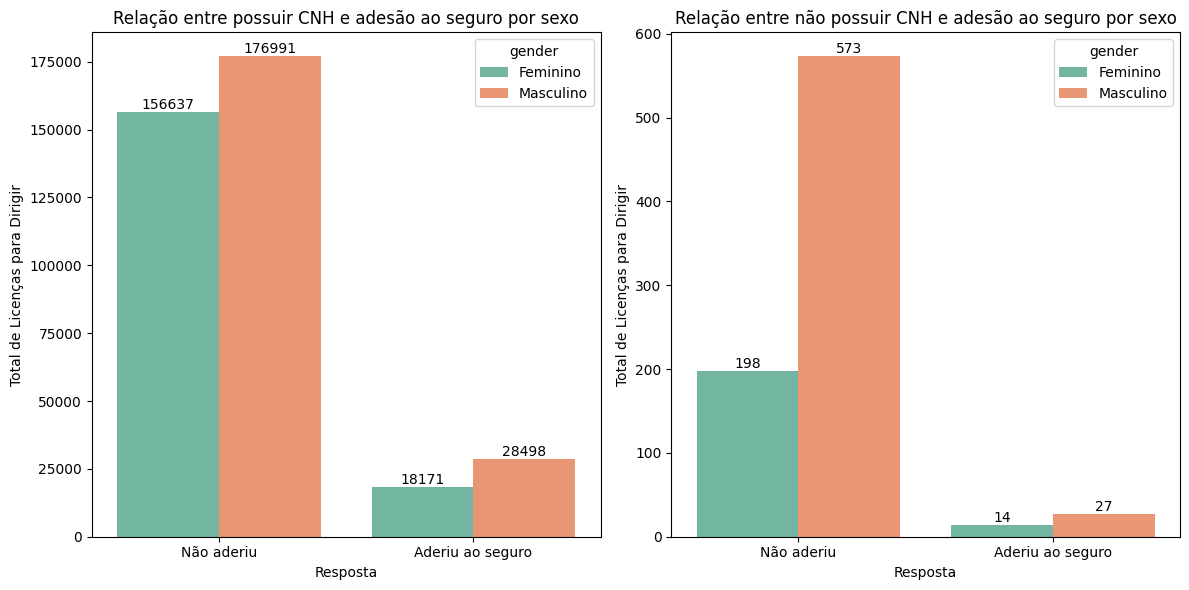

In [74]:
# Filtro
df_filtered_1 = df4[df4['driving_license'] == 1]
df_filtered_0 = df4[df4['driving_license'] == 0]

# Calcular a contagem de pessoas com CNH que aderiram ao seguro por sexo
aux_gender_1 = df_filtered_1.groupby(['response', 'gender']).size().reset_index(name='count')
aux_gender_1['response'] = aux_gender_1['response'].replace({0: 'Não aderiu', 1: 'Aderiu ao seguro'})
aux_gender_1['gender'] = aux_gender_1['gender'].replace({'Male': 'Masculino', 'Female': 'Feminino'})

# Calcular a contagem de pessoas sem CNH que aderiram ao seguro por sexo
aux_gender_0 = df_filtered_0.groupby(['response', 'gender']).size().reset_index(name='count')
aux_gender_0['response'] = aux_gender_0['response'].replace({0: 'Não aderiu', 1: 'Aderiu ao seguro'})
aux_gender_0['gender'] = aux_gender_0['gender'].replace({'Male': 'Masculino', 'Female': 'Feminino'})

# Criar uma figura com duas subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1 - CNH e adesão ao seguro
sns.barplot(x='response', y='count', hue='gender', data=aux_gender_1, palette='Set2', ax=axes[0])
axes[0].set_xlabel('Resposta')
axes[0].set_ylabel('Total de Licenças para Dirigir')
axes[0].set_title('Relação entre possuir CNH e adesão ao seguro por sexo')

# Adicionar números acima das barras no gráfico 1
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

# Gráfico 2 - Não CNH e adesão ao seguro
sns.barplot(x='response', y='count', hue='gender', data=aux_gender_0, palette='Set2', ax=axes[1])
axes[1].set_xlabel('Resposta')
axes[1].set_ylabel('Total de Licenças para Dirigir')
axes[1].set_title('Relação entre não possuir CNH e adesão ao seguro por sexo')

# Adicionar números acima das barras no gráfico 2
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

# Ajustar o espaçamento entre as subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()

## 4.5 previously_insured

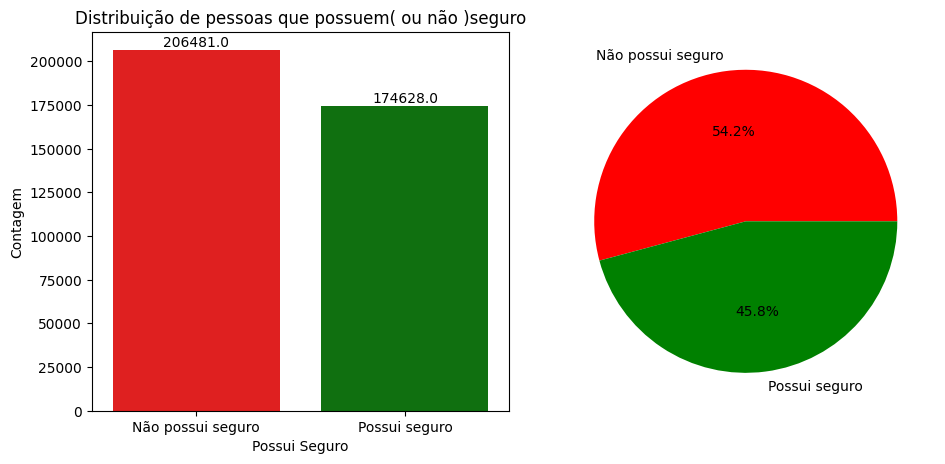

In [75]:
# Filtro
count_insured = df4['previously_insured'].value_counts().reset_index()
count_insured.columns = ['Possui Seguro', 'Count']

# Renomear legenda
count_insured['Possui Seguro'] = count_insured['Possui Seguro'].replace({0: 'Não possui seguro', 1: 'Possui seguro'})

# Calcular as porcentagens
count_insured['Percentage'] = count_insured['Count'] / count_insured['Count'].sum() * 100

# Definir as cores personalizadas
colors = ['red', 'green']

# Criar a grade de subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot - Gráfico de Barras
sns.barplot(x='Possui Seguro', y='Count', data=count_insured, palette=colors, ax=ax1)
ax1.set_xlabel('Possui Seguro')
ax1.set_ylabel('Contagem')
ax1.set_title('Distribuição de pessoas que possuem( ou não )seguro')

# Adicionar os números em cima das barras
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Plot - Gráfico de Pizza
ax2.pie(count_insured['Percentage'], labels=count_insured['Possui Seguro'], colors=colors, autopct='%1.1f%%')

# Ajustar o layout
plt.tight_layout(pad=2)

# Exibir os gráficos
plt.show()


### 4.5.1 Distrubuição das pessoas que possuem seguro(ou não ) por sexo

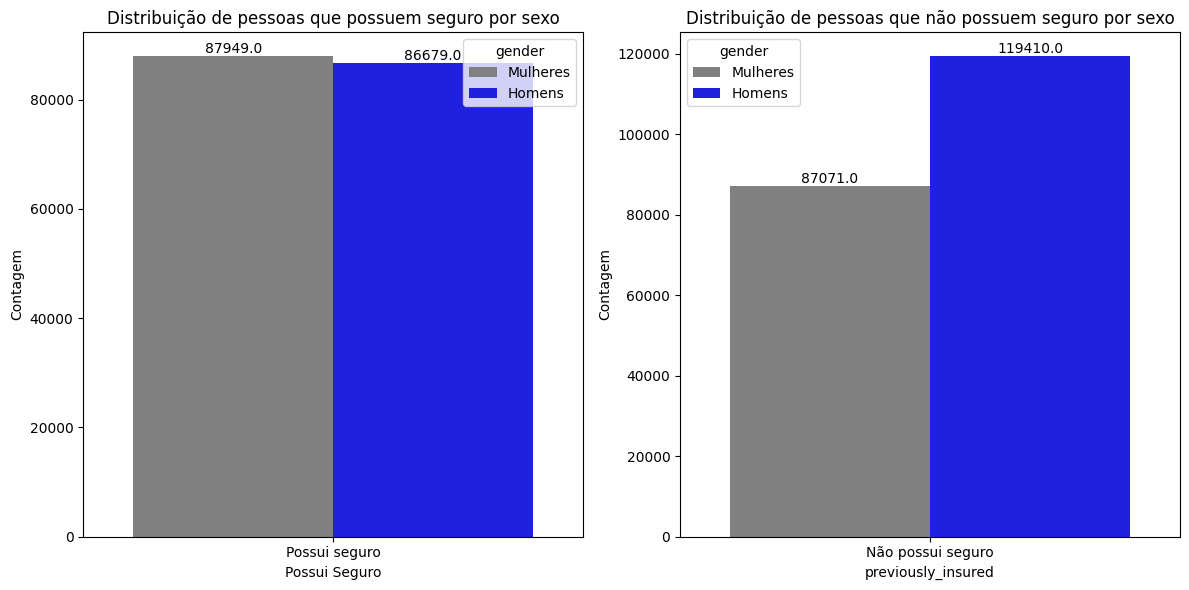

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtro
df_filtered = df4[df4['previously_insured'].isin([0, 1])]

# Calcular a contagem de pessoas que possuem ou não seguro por sexo
count_insured_gender = df_filtered.groupby(['previously_insured', 'gender']).size().reset_index(name='count')

# Renomear as categorias e o sexo para exibir na legenda
count_insured_gender['previously_insured'] = count_insured_gender['previously_insured'].replace({0: 'Não possui seguro', 1: 'Possui seguro'})
count_insured_gender['gender'] = count_insured_gender['gender'].replace({'Male': 'Homens', 'Female': 'Mulheres'})

# Definir as cores personalizadas
colors = {'Homens': 'blue', 'Mulheres': 'gray'}

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico para pessoas que possuem seguro
sns.barplot(x='previously_insured', y='count', hue='gender', data=count_insured_gender[count_insured_gender['previously_insured'] == 'Possui seguro'], palette=colors, ax=ax1)
ax1.set_xlabel('Possui Seguro')
ax1.set_ylabel('Contagem')
ax1.set_title('Distribuição de pessoas que possuem seguro por sexo')

# Adicionar os números em cima das barras
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Gráfico para pessoas que não possuem seguro
sns.barplot(x='previously_insured', y='count', hue='gender', data=count_insured_gender[count_insured_gender['previously_insured'] == 'Não possui seguro'], palette=colors, ax=ax2)
ax2.set_ylabel('Contagem')
ax2.set_title('Distribuição de pessoas que não possuem seguro por sexo')

# Adicionar os números em cima das barras
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 4.6 vehicle_damage


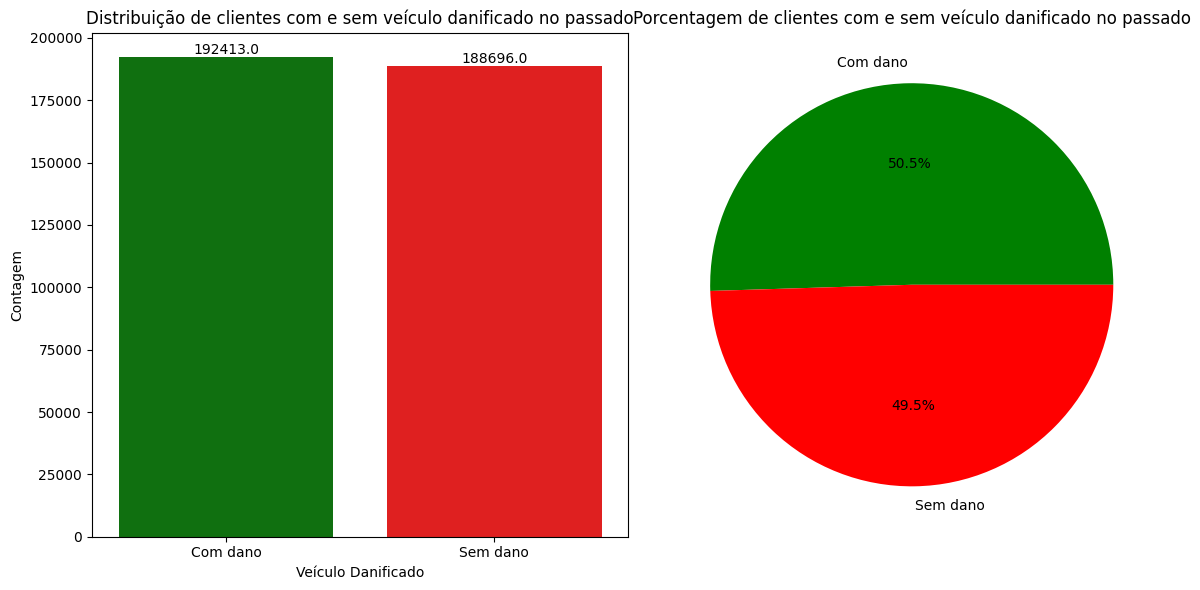

In [77]:
# Calcular a contagem de clientes com e sem veículo danificado no passado
count_vehicle_damage = df4['vehicle_damage'].value_counts().reset_index()
count_vehicle_damage.columns = ['Veículo Danificado', 'Count']

# Renomear os valores para exibir na legenda
count_vehicle_damage['Veículo Danificado'] = count_vehicle_damage['Veículo Danificado'].replace({0: 'Sem dano', 1: 'Com dano'})

# Definir as cores personalizadas para o gráfico de barras
colors = ['green', 'red']

# Criar a figura e os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de barras
sns.barplot(x='Veículo Danificado', y='Count', data=count_vehicle_damage, palette=colors, ax=ax1)
ax1.set_xlabel('Veículo Danificado')
ax1.set_ylabel('Contagem')
ax1.set_title('Distribuição de clientes com e sem veículo danificado no passado')

# Adicionar os números em cima das barras
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

# Gráfico de pizza
count_vehicle_damage_pie = count_vehicle_damage.set_index('Veículo Danificado')
ax2.pie(count_vehicle_damage_pie['Count'], labels=count_vehicle_damage_pie.index, autopct='%1.1f%%', colors=colors)
ax2.set_title('Porcentagem de clientes com e sem veículo danificado no passado')

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()


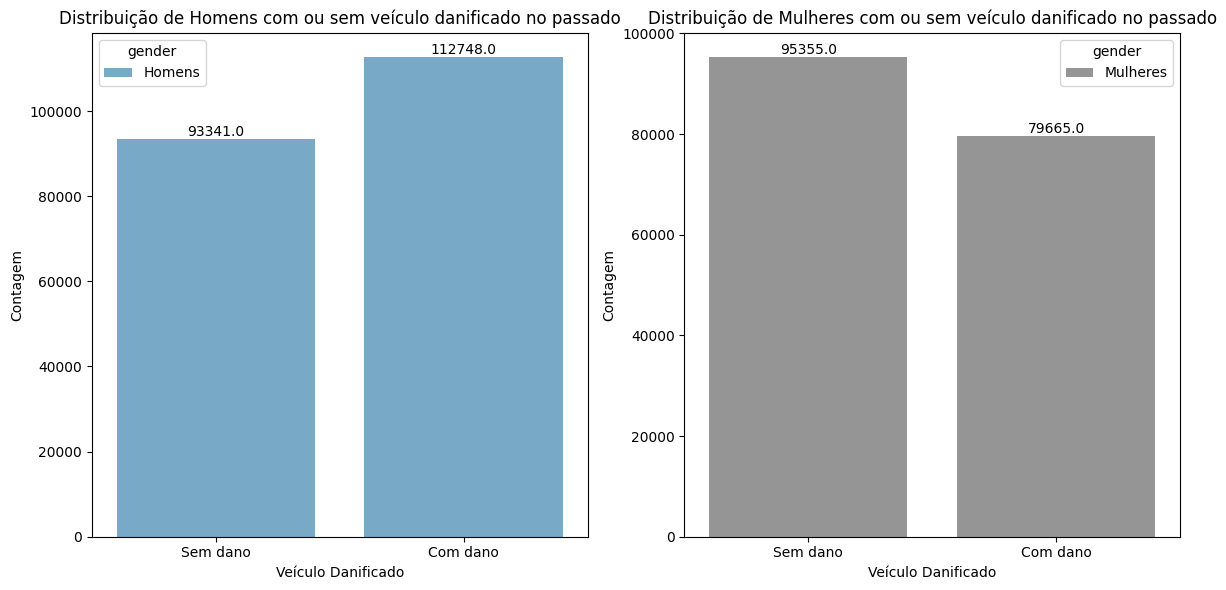

In [78]:
# Filtro
count_vehicle_damage_gender = df4.groupby(['vehicle_damage', 'gender']).size().reset_index(name='count')

# Renomear as legendas
count_vehicle_damage_gender['vehicle_damage'] = count_vehicle_damage_gender['vehicle_damage'].replace({0: 'Sem dano', 1: 'Com dano'})
count_vehicle_damage_gender['gender'] = count_vehicle_damage_gender['gender'].replace({'Male': 'Homens', 'Female': 'Mulheres'})

# Criar uma figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico para homens com veículo danificado ou não danificado no passado
sns.barplot(x='vehicle_damage', y='count', hue='gender', data=count_vehicle_damage_gender[count_vehicle_damage_gender['gender'] == 'Homens'], ax=ax1, palette='Blues')
ax1.set_xlabel('Veículo Danificado')
ax1.set_ylabel('Contagem')
ax1.set_title('Distribuição de Homens com ou sem veículo danificado no passado')

# Adicionar os números em cima das barras no gráfico de homens
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

# Gráfico para mulheres com veículo danificado ou não danificado no passado
sns.barplot(x='vehicle_damage', y='count', hue='gender', data=count_vehicle_damage_gender[count_vehicle_damage_gender['gender'] == 'Mulheres'], palette='Greys', ax=ax2)
ax2.set_xlabel('Veículo Danificado')
ax2.set_ylabel('Contagem')
ax2.set_title('Distribuição de Mulheres com ou sem veículo danificado no passado')

# Adicionar os números em cima das barras no gráfico de mulheres
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

# Ajustar espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()


## 4.7 annual_premium

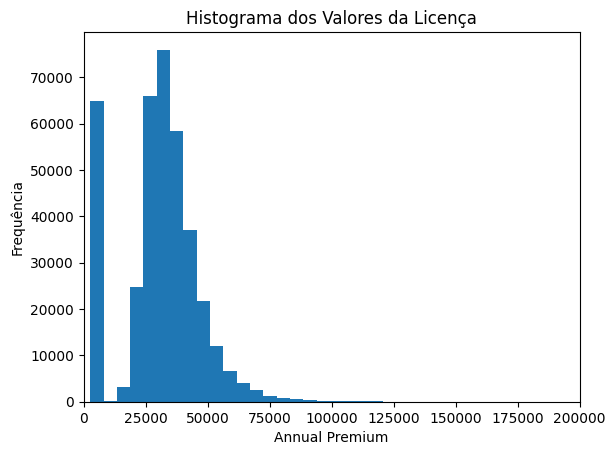

In [79]:
import matplotlib.pyplot as plt

plt.hist(df4['annual_premium'], bins=100)
plt.xlabel('Annual Premium')
plt.ylabel('Frequência')
plt.title('Histograma dos Valores da Licença')
plt.xlim(0, 200000)  # Definindo os limites do eixo x
plt.show()


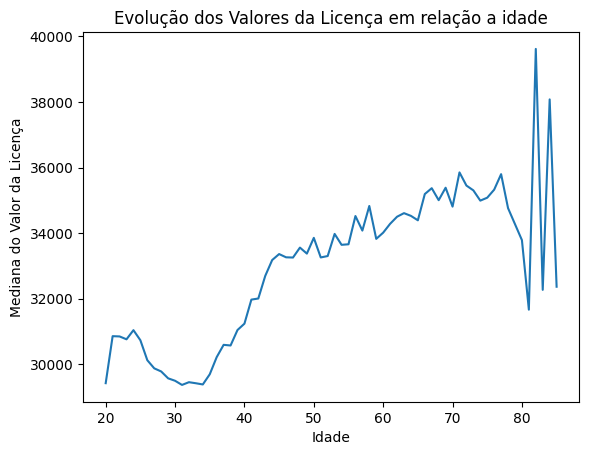

In [80]:
df4.groupby('age')['annual_premium'].median().plot(kind='line')
plt.xlabel('Idade')
plt.ylabel('Mediana do Valor da Licença')
plt.title('Evolução dos Valores da Licença em relação a idade')
plt.show()

## 4.8 policy_sales_channel

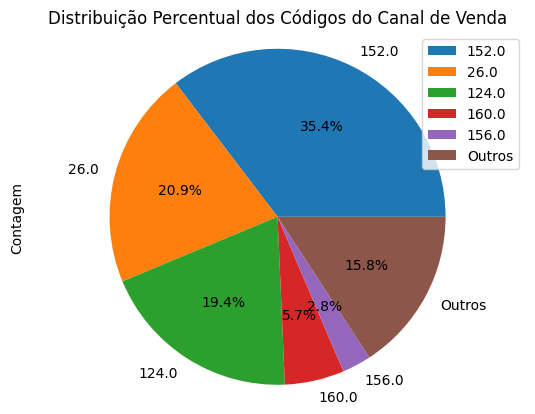

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Converte os valores do código do canal de venda para strings
df4['policy_sales_channel'] = df4['policy_sales_channel'].astype(str)

# Calcula a contagem de frequência dos códigos do canal de venda
counts = df4['policy_sales_channel'].value_counts()

# Separa os cinco códigos mais frequentes dos demais
top5 = counts.head(5)
others = counts[5:].sum()

# Cria um novo DataFrame com os cinco códigos mais frequentes e o valor "Outros"
data = {'Código do Canal de Venda': top5.index.tolist() + ['Outros'],
        'Contagem': top5.tolist() + [others]}
new_df = pd.DataFrame(data)

# Plota o gráfico de pizza com base no novo DataFrame
new_df.plot(kind='pie', y='Contagem', labels=new_df['Código do Canal de Venda'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribuição Percentual dos Códigos do Canal de Venda')
plt.show()


## 4.9 vintage

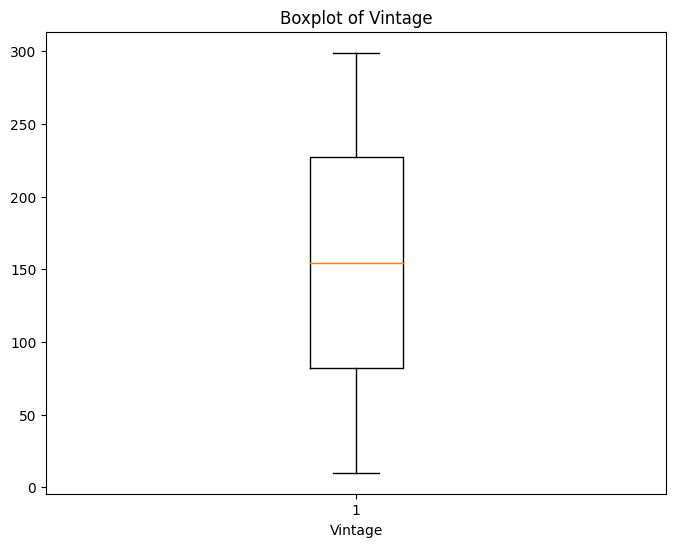

In [82]:
# Boxplot para a variável 'vintage'
plt.figure(figsize=(8, 6))
plt.boxplot(df4['vintage'])
plt.xlabel('Vintage')
plt.title('Boxplot of Vintage')
plt.show()

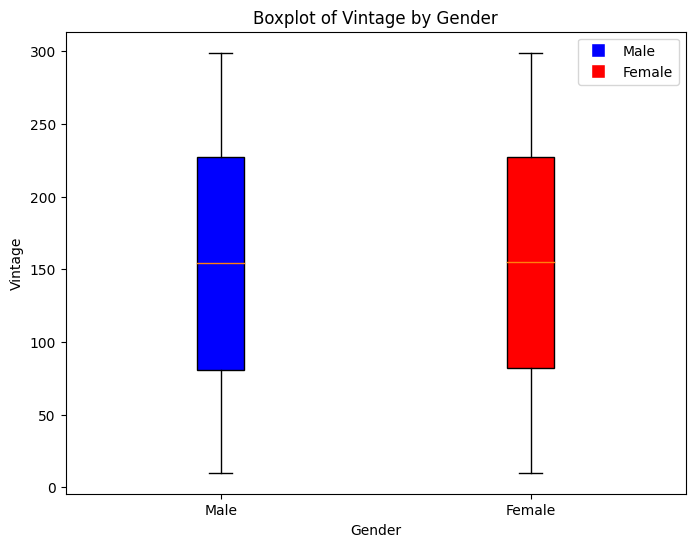

In [83]:
import matplotlib.pyplot as plt

# Separar os dados por gênero
vintage_male = df4[df4['gender'] == 'Male']['vintage']
vintage_female = df4[df4['gender'] == 'Female']['vintage']

# Configurar as cores para os boxplots
box_colors = ['blue', 'red']

# Boxplot para homens e mulheres com cores personalizadas
plt.figure(figsize=(8, 6))
bp = plt.boxplot([vintage_male, vintage_female], labels=['Male', 'Female'], patch_artist=True)

# Personalizar as cores dos elementos dos boxplots
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)

# Ajustar a legenda manualmente
legend_labels = ['Male', 'Female']
legend_patches = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10) for color in box_colors]
plt.legend(legend_patches, legend_labels)

plt.xlabel('Gender')
plt.ylabel('Vintage')
plt.title('Boxplot of Vintage by Gender')
plt.show()


## 4.10 Vehicle_age

In [84]:
df4['vehicle_age'].unique()

array(['over_2_years', 'between_1_2_year', 'below_1_year'], dtype=object)

## 4.10.1 Distribuição da idade dos veículos

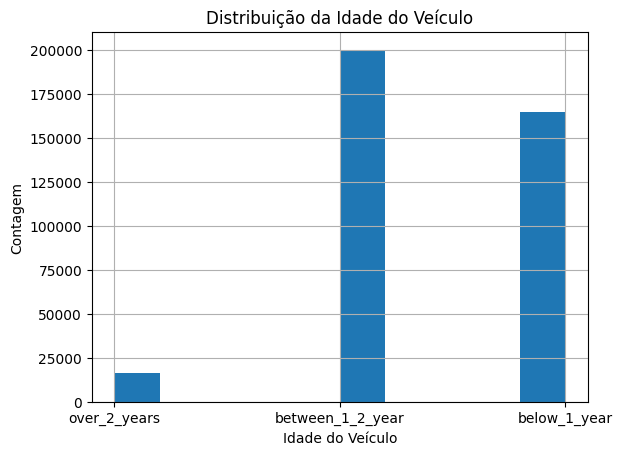

In [85]:
df4['vehicle_age'].hist()
plt.title('Distribuição da Idade do Veículo')
plt.xlabel('Idade do Veículo')
plt.ylabel('Contagem')
plt.show()

## 4.10.2 Relação entre a idade do veículo e adesão ao seguro :

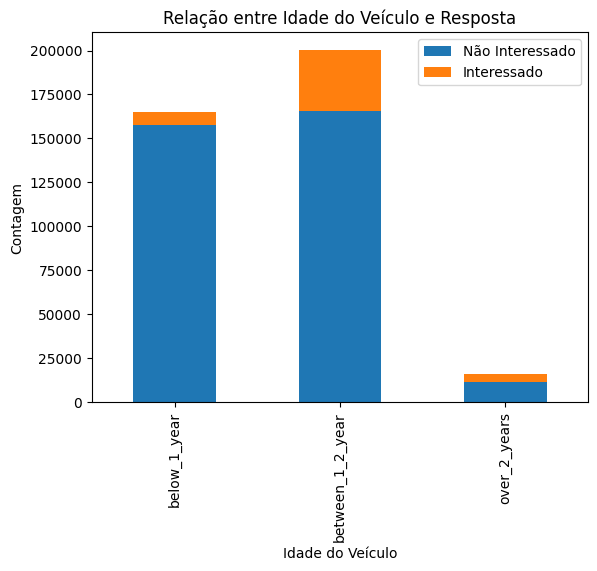

In [86]:
age_response_counts = df4.groupby(['vehicle_age', 'response']).size().unstack()
age_response_counts.plot(kind='bar', stacked=True)
plt.title('Relação entre Idade do Veículo e Resposta')
plt.xlabel('Idade do Veículo')
plt.ylabel('Contagem')
plt.legend(['Não Interessado', 'Interessado'])
plt.show()


## 4.10.3 Idade do veículo por gênero :

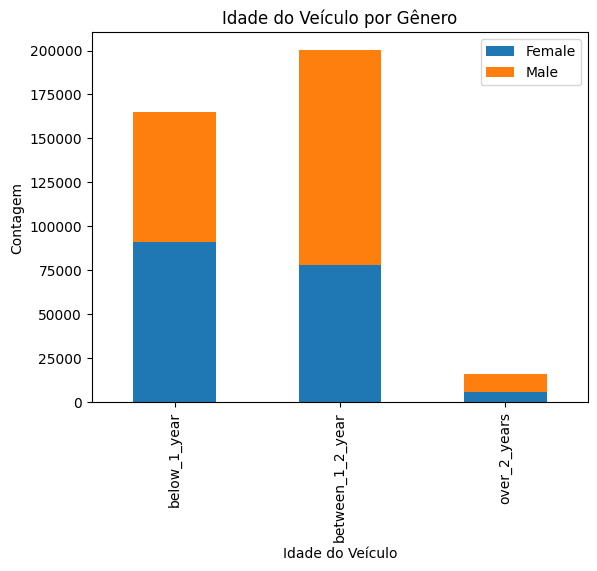

In [87]:
age_gender_counts = df4.groupby(['vehicle_age', 'gender']).size().unstack()
age_gender_counts.plot(kind='bar', stacked=True)
plt.title('Idade do Veículo por Gênero')
plt.xlabel('Idade do Veículo')
plt.ylabel('Contagem')
plt.legend(['Female', 'Male'])
plt.show()

# 5.0 Preparação dos dados

In [88]:
df5 = df4.copy()
df5.drop(['id','response_label'], axis=1, inplace=True)

In [89]:
le = LabelEncoder()
scaler = MinMaxScaler()

df5['gender_encoded'] = le.fit_transform(df5['gender'])

age_bins = [20, 30, 40, 50, 60, 70, 80, 90]  # Defina as faixas etárias adequadas
age_labels = ['20-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-85']  # Labels para cada faixa etária
df5['age_encoded'] = pd.cut(df5['age'], bins=age_bins, labels=age_labels)
df5['age_encoded'] = le.fit_transform(df5['age_encoded'])

df5['driving_license_scaled'] = scaler.fit_transform(df5[['driving_license']])

df5['region_code_scaled'] = scaler.fit_transform(df5[['region_code']])

df5['previously_insured_scaled'] = scaler.fit_transform(df5[['previously_insured']])

# Codificar as categorias da coluna "vehicle_age"
le = LabelEncoder()
df5['vehicle_age_encoded'] = le.fit_transform(df5['vehicle_age'])
df5['vehicle_age_scaled'] = scaler.fit_transform(df5[['vehicle_age_encoded']])

df5['vehicle_damage_scaled'] = scaler.fit_transform(df5[['vehicle_damage']])

df5['annual_premium_scaled'] = scaler.fit_transform(df5[['annual_premium']])

df5['policy_sales_channel_scaled'] = scaler.fit_transform(df5[['policy_sales_channel']])

df5['vintage_scaled'] = scaler.fit_transform(df5[['vintage']])

columns_to_drop = ['gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age_encoded', 
                   'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage','vehicle_age']
df5.drop(columns_to_drop, axis=1, inplace=True)


# 6.0 Feature Selection

In [90]:
X = df5.drop('response', axis=1) 
y = df5['response'] 

## 6.1 Matriz de correlação 

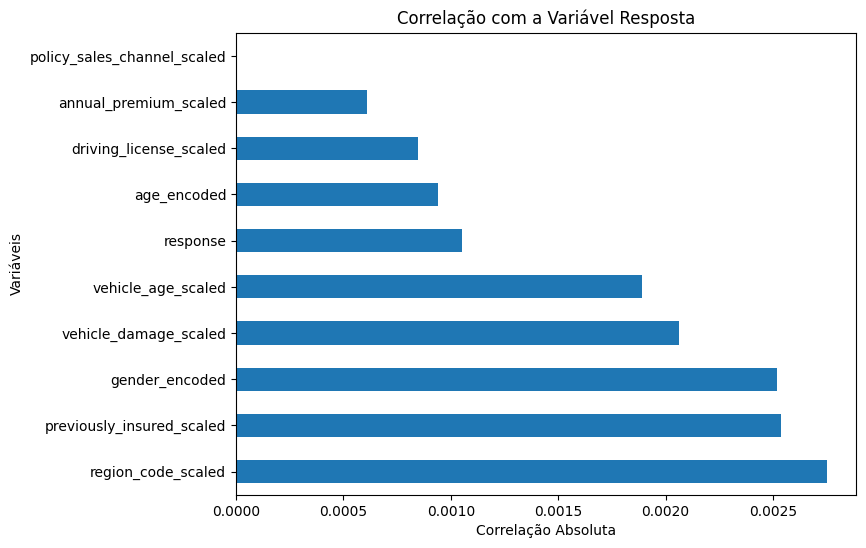

In [91]:
# Calcular a matriz de correlação
correlation_matrix = df5.corr()

# Obter as correlações absolutas com a variável resposta
correlation_with_target = correlation_matrix.iloc[:-1, -1].abs().sort_values(ascending=False)

# Plotar o gráfico de barras horizontais
plt.figure(figsize=(8, 6))
correlation_with_target.plot(kind='barh')
plt.xlabel('Correlação Absoluta')
plt.ylabel('Variáveis')
plt.title('Correlação com a Variável Resposta')
plt.show()

## 6.2 Seleção por Random Forest

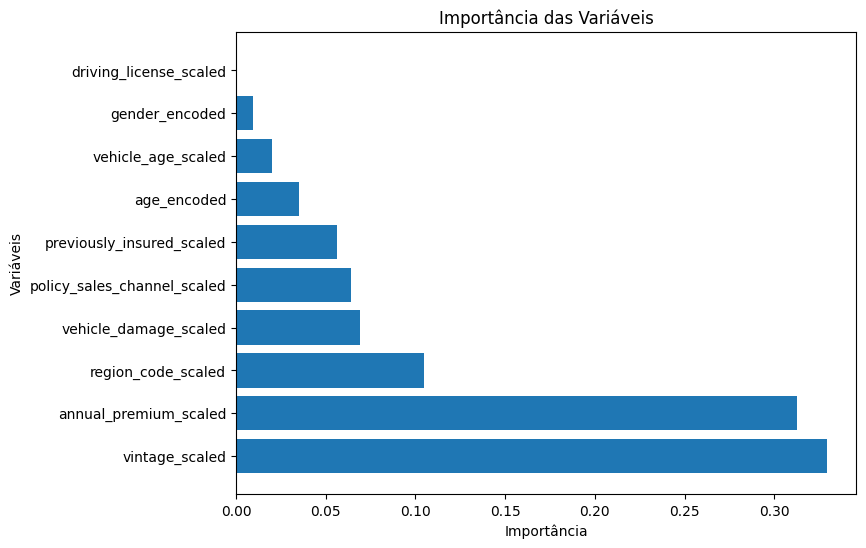

In [92]:
# Criar um modelo de Random Forest
rf = RandomForestClassifier()

# Treinar o modelo usando as variáveis independentes (X) e a variável resposta (y)
rf.fit(X, y)

# Obter a importância das variáveis
importance = rf.feature_importances_

# Criar um dataframe para exibir a importância das variáveis
importance_df = pd.DataFrame({'Variável': X.columns, 'Importância': importance})
importance_df = importance_df.sort_values(by='Importância', ascending=False)

# Plotar o gráfico de barras horizontais com a importância das variáveis
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Variável'], importance_df['Importância'])
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis')
plt.show()

## 6.3 Seleção por Gradient boosting

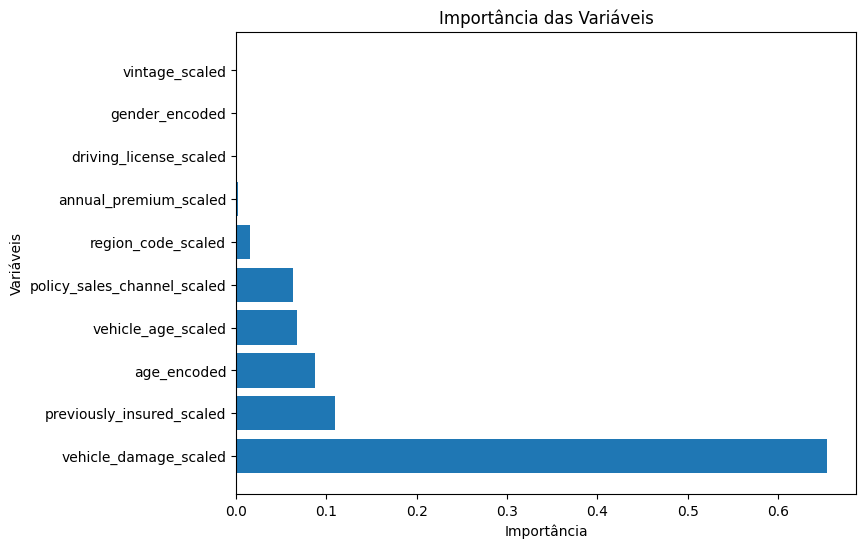

In [93]:
# Criar um modelo de Gradient Boosting
gb = GradientBoostingClassifier()

# Treinar o modelo usando as variáveis independentes (X) e a variável resposta (y)
gb.fit(X, y)

# Obter a importância das variáveis
importance = gb.feature_importances_

# Criar um dataframe para exibir a importância das variáveis
importance_df = pd.DataFrame({'Variável': X.columns, 'Importância': importance})
importance_df = importance_df.sort_values(by='Importância', ascending=False)

# Plotar o gráfico de barras horizontais com a importância das variáveis
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Variável'], importance_df['Importância'])
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis')
plt.show()


# 6.0 Machine Learning

In [94]:
cols_selected = ['vehicle_damage_scaled', 'vintage_scaled', 'annual_premium_scaled','age_encoded']

In [95]:
# Selecionar apenas as colunas escolhidas
X_selected = X[cols_selected]

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# X_train: conjunto de treinamento das variáveis independentes selecionadas
# X_test: conjunto de teste das variáveis independentes selecionadas
# y_train: conjunto de treinamento da variável resposta
# y_test: conjunto de teste da variável resposta

# 6.1 Random Forest

In [96]:
## Criar o modelo
#random_forest = RandomForestClassifier()

## Treinar o modelo
#random_forest.fit(X_train, y_train)

## Fazer as previsões
#rf_probabilities = random_forest.predict_proba(X_test)

### 6.1.1 Métricas de desempenho  

In [97]:
## Curva de Ganho Acumulado
#skplt.metrics.plot_cumulative_gain(y_test, rf_probabilities)

## Curva de Lift
#skplt.metrics.plot_lift_curve(y_test, rf_probabilities)

# 6.2 Gradient Boosting


In [98]:
## Criar o modelo
#gradient_boosting = GradientBoostingClassifier()

## Treinar o modelo
#gradient_boosting.fit(X_train, y_train)

## Fazer as previsões
#gb_predictions =  gradient_boosting.predict_proba(X_test)

### 6.2.1 Métricas de desempenho  

In [99]:
## Curva de Ganho Acumulado
#skplt.metrics.plot_cumulative_gain(y_test, gb_predictions)

## Curva de Lift
#skplt.metrics.plot_lift_curve(y_test, gb_predictions)

### 6.3 XGBoost

In [100]:
## Criar o modelo
#xgboost = xgb.XGBClassifier()

## Treinar o modelo
#xgboost.fit(X_train, y_train)

## Fazer as previsões
#xgb_predictions = xgboost.predict_proba(X_test)

### 6.3.1 Métricas de desempenho  

In [101]:
## Curva de Ganho Acumulado
#skplt.metrics.plot_cumulative_gain(y_test, xgb_predictions)

## Curva de Lift
#skplt.metrics.plot_lift_curve(y_test, xgb_predictions)

## 6.4 KNN

In [102]:
## Criar o modelo KNN
#knn_model = KNeighborsClassifier(n_neighbors=7)

## Treinar o modelo KNN
#knn_model.fit(X_train, y_train)

## Fazer as previsões com o modelo KNN
#knn_predictions = knn_model.predict_proba(X_test)

### 6.4.1 Métricas de desempenho

In [103]:
## Curva de Ganho Acumulado
#skplt.metrics.plot_cumulative_gain(y_test, knn_predictions)

## Curva de Lift
#skplt.metrics.plot_lift_curve(y_test, knn_predictions)

# 7.0 Fine Tuning

In [104]:
## Definir os hiperparâmetros a serem ajustados
#parameters = {
    #'n_estimators': [100, 200, 300],  # Número de árvores
    #'max_depth': [3, 4, 5],  # Profundidade máxima de cada árvore
    #'learning_rate': [0.1, 0.01, 0.001]  # Taxa de aprendizado
#}

## Criar o modelo
#xgboost = xgb.XGBClassifier()

## Realizar a busca em grade (grid search) para encontrar a melhor combinação de hiperparâmetros
#grid_search = GridSearchCV(estimator=xgboost, param_grid=parameters, cv=3)
#grid_search.fit(X_train, y_train)

## Obter os melhores hiperparâmetros encontrados
#best_params = grid_search.best_params_
#print("Melhores hiperparâmetros encontrados:", best_params)

### 7.1 Xgboost ajustada

In [105]:
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

# Criar um novo modelo com os melhores hiperparâmetros
best_xgboost = xgb.XGBClassifier(**best_params)

# Treinar o modelo com os melhores hiperparâmetros
best_xgboost.fit(X_train, y_train)

# Fazer as previsões com o modelo ajustado
best_xgb_predictions = best_xgboost.predict_proba(X_test)



In [106]:
# Salvar o modelo em um arquivo
with open('model.pkl', 'wb') as f:
    pickle.dump(best_xgboost, f)

In [107]:
# Extrair as probabilidades da classe positiva
positive_probabilities = best_xgb_predictions[:, 1]

# Criar um índice numérico para representar os clientes
client_indices = np.arange(len(X_test))

# Criar um DataFrame com os índices e as probabilidades da classe positiva
predictions_df = pd.DataFrame({'ClienteID': client_indices, 'Probabilidade': positive_probabilities})

# Ordenar o DataFrame pela coluna de probabilidades em ordem decrescente
predictions_df = predictions_df.sort_values(by='Probabilidade', ascending=False)

predictions_df

,ClienteID,Probabilidade
38192,38192,0.496296
25602,25602,0.464509
8226,8226,0.455110
69916,69916,0.451804
68995,68995,0.448490
...,...,...
44298,44298,0.000526
29335,29335,0.000526
45373,45373,0.000526
65150,65150,0.000526
